In [1]:
from importlib import reload
import dataset as d; reload(d)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

In [2]:
df = d.load_dataset()

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Create X and Y

In [4]:
PREDICTED_COLUMNS = ['radius_mean', 'diagnosis']
FEATURES_PREFIX = 'mean'

In [5]:
x, y = d.create_xy(df, FEATURES_PREFIX, PREDICTED_COLUMNS)

In [6]:
x = d.preprocess_data(x)

## Split Train, Val & Test

### Train & Val

In [7]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = d.split_train_val_test(x, y, train_perc=0.8)

In [8]:
print('# Examples for training:', len(x_train))
print('# Examples for validation:', len(x_val))
print('# Examples for test:',  len(x_test))

# Examples for training: 285
# Examples for validation: 142
# Examples for test: 142


## Ensemble of models

### Create an ensemble of models

In [9]:
import keras
from keras.layers import *
from keras.models import Model, Sequential
from keras.regularizers import l1_l2
from collections import defaultdict

c:\users\bearch\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
N_FEATURES = x_train.shape[1]

In [11]:
def create_base_model(input_size, n_hidden):
    i = Input((input_size, ))
    h = Dense(n_hidden, kernel_initializer='normal', use_bias=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(i)
#     h = Dropout(0.6)(h)
    h = LeakyReLU()(h)
    o = Dense(1)(h)
    return Model(i, o)

In [12]:
models = []
N_MODELS = 5
n_hidden_neurons = 64
for _ in range(N_MODELS):
    models.append(create_base_model(N_FEATURES, n_hidden_neurons))

In [13]:
models[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


### Train ensemble

In [14]:
def train(model, train_data, val_data, lr, batch_size, epochs=50, history=None):
    current_epoch = 0 if history is None else len(history.history['loss'])
    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(lr=lr),
        metrics=['mse']
    )
    
    new_history = model.fit(
        train_data[0], train_data[1], epochs=current_epoch+epochs,
        batch_size=batch_size,
        validation_data=val_data,
        initial_epoch=current_epoch,
        verbose=1
    )
    
    if history is not None:
        for key in new_history.history:
            history.history[key].extend(new_history.history[key])
    else:
        history = new_history
    
    return history

In [15]:
histories = defaultdict(lambda: None)

In [16]:
for lr in [0.5, 0.1, 0.05, 0.01]:
    for i in range(N_MODELS):
        histories[i] = train(models[i], [x_train, y_train[:, 0]], (x_val, y_val[:, 0]), lr, 500, history=histories[i])

Train on 285 samples, validate on 142 samples
Epoch 1/50
285/285 [==============================] - 3s 9ms/step - loss: 151.3708 - mean_squared_error: 151.1178 - val_loss: 25.7273 - val_mean_squared_error: 22.7586
Epoch 2/50
285/285 [==============================] - 0s 17us/step - loss: 11.2205 - mean_squared_error: 8.2517 - val_loss: 3867.8242 - val_mean_squared_error: 3861.6946
Epoch 3/50
285/285 [==============================] - 0s 17us/step - loss: 2450.0498 - mean_squared_error: 2443.9202 - val_loss: 41.5998 - val_mean_squared_error: 36.7887
Epoch 4/50
285/285 [==============================] - 0s 17us/step - loss: 35.7989 - mean_squared_error: 30.9878 - val_loss: 1117.1323 - val_mean_squared_error: 1112.3737
Epoch 5/50
285/285 [==============================] - 0s 17us/step - loss: 634.5375 - mean_squared_error: 629.7789 - val_loss: 995.9312 - val_mean_squared_error: 992.1730
Epoch 6/50
285/285 [==============================] - 0s 25us/step - loss: 568.3297 - mean_squared_erro

Epoch 50/50
285/285 [==============================] - 0s 21us/step - loss: 9.6689 - mean_squared_error: 0.7719 - val_loss: 10.3745 - val_mean_squared_error: 1.5274
Train on 285 samples, validate on 142 samples
Epoch 1/50
285/285 [==============================] - 0s 1ms/step - loss: 152.1996 - mean_squared_error: 151.9642 - val_loss: 34.8669 - val_mean_squared_error: 31.9374
Epoch 2/50
285/285 [==============================] - 0s 49us/step - loss: 16.4698 - mean_squared_error: 13.5403 - val_loss: 3794.3083 - val_mean_squared_error: 3788.5520
Epoch 3/50
285/285 [==============================] - 0s 49us/step - loss: 2374.9111 - mean_squared_error: 2369.1548 - val_loss: 85.9140 - val_mean_squared_error: 81.3384
Epoch 4/50
285/285 [==============================] - 0s 28us/step - loss: 64.8205 - mean_squared_error: 60.2449 - val_loss: 747.6371 - val_mean_squared_error: 742.9677
Epoch 5/50
285/285 [==============================] - 0s 28us/step - loss: 421.0133 - mean_squared_error: 416.

Epoch 49/50
285/285 [==============================] - 0s 28us/step - loss: 7.3760 - mean_squared_error: 0.9067 - val_loss: 13.8768 - val_mean_squared_error: 7.5062
Epoch 50/50
285/285 [==============================] - 0s 35us/step - loss: 9.4299 - mean_squared_error: 3.0593 - val_loss: 15.5392 - val_mean_squared_error: 9.2526
Train on 285 samples, validate on 142 samples
Epoch 1/50
285/285 [==============================] - 0s 1ms/step - loss: 152.0832 - mean_squared_error: 151.8567 - val_loss: 11.3862 - val_mean_squared_error: 8.4280
Epoch 2/50
285/285 [==============================] - 0s 17us/step - loss: 9.4137 - mean_squared_error: 6.4555 - val_loss: 1635.7289 - val_mean_squared_error: 1630.6459
Epoch 3/50
285/285 [==============================] - 0s 25us/step - loss: 944.1059 - mean_squared_error: 939.0228 - val_loss: 465.0486 - val_mean_squared_error: 459.3657
Epoch 4/50
285/285 [==============================] - 0s 17us/step - loss: 319.6348 - mean_squared_error: 313.9519 - 

Epoch 48/50
285/285 [==============================] - 0s 17us/step - loss: 6.1082 - mean_squared_error: 2.1365 - val_loss: 9.5066 - val_mean_squared_error: 5.5625
Epoch 49/50
285/285 [==============================] - 0s 24us/step - loss: 6.3437 - mean_squared_error: 2.3996 - val_loss: 9.6854 - val_mean_squared_error: 5.7892
Epoch 50/50
285/285 [==============================] - 0s 21us/step - loss: 6.0510 - mean_squared_error: 2.1549 - val_loss: 11.5649 - val_mean_squared_error: 7.7310
Train on 285 samples, validate on 142 samples
Epoch 1/50
285/285 [==============================] - 0s 1ms/step - loss: 149.9579 - mean_squared_error: 149.7182 - val_loss: 16.0367 - val_mean_squared_error: 13.0695
Epoch 2/50
285/285 [==============================] - 0s 24us/step - loss: 7.8967 - mean_squared_error: 4.9295 - val_loss: 3765.4844 - val_mean_squared_error: 3759.3159
Epoch 3/50
285/285 [==============================] - 0s 17us/step - loss: 2370.9907 - mean_squared_error: 2364.8223 - val_l

Epoch 47/50
285/285 [==============================] - 0s 21us/step - loss: 8.0497 - mean_squared_error: 2.2229 - val_loss: 20.3789 - val_mean_squared_error: 14.6247
Epoch 48/50
285/285 [==============================] - 0s 24us/step - loss: 11.0441 - mean_squared_error: 5.2898 - val_loss: 14.4309 - val_mean_squared_error: 8.7134
Epoch 49/50
285/285 [==============================] - 0s 24us/step - loss: 8.6251 - mean_squared_error: 2.9076 - val_loss: 7.0764 - val_mean_squared_error: 1.3706
Epoch 50/50
285/285 [==============================] - 0s 31us/step - loss: 6.4196 - mean_squared_error: 0.7138 - val_loss: 7.4406 - val_mean_squared_error: 1.7489
Train on 285 samples, validate on 142 samples
Epoch 1/50
285/285 [==============================] - 0s 1ms/step - loss: 149.0809 - mean_squared_error: 148.8443 - val_loss: 9.8173 - val_mean_squared_error: 6.8570
Epoch 2/50
285/285 [==============================] - 0s 17us/step - loss: 7.1367 - mean_squared_error: 4.1765 - val_loss: 1366.

Epoch 46/50
285/285 [==============================] - 0s 28us/step - loss: 9.9345 - mean_squared_error: 4.0819 - val_loss: 9.4965 - val_mean_squared_error: 3.7156
Epoch 47/50
285/285 [==============================] - 0s 31us/step - loss: 8.3890 - mean_squared_error: 2.6081 - val_loss: 12.4430 - val_mean_squared_error: 6.7414
Epoch 48/50
285/285 [==============================] - 0s 21us/step - loss: 7.3237 - mean_squared_error: 1.6221 - val_loss: 17.4169 - val_mean_squared_error: 11.7946
Epoch 49/50
285/285 [==============================] - 0s 24us/step - loss: 8.0643 - mean_squared_error: 2.4419 - val_loss: 19.4553 - val_mean_squared_error: 13.9061
Epoch 50/50
285/285 [==============================] - 0s 21us/step - loss: 8.6382 - mean_squared_error: 3.0890 - val_loss: 16.2999 - val_mean_squared_error: 10.8178
Train on 285 samples, validate on 142 samples
Epoch 51/100
285/285 [==============================] - 0s 1ms/step - loss: 11.1721 - mean_squared_error: 2.3251 - val_loss: 13

Epoch 95/100
285/285 [==============================] - 0s 31us/step - loss: 7.7237 - mean_squared_error: 1.0042 - val_loss: 9.5637 - val_mean_squared_error: 2.8803
Epoch 96/100
285/285 [==============================] - 0s 17us/step - loss: 7.4236 - mean_squared_error: 0.7401 - val_loss: 8.1444 - val_mean_squared_error: 1.4837
Epoch 97/100
285/285 [==============================] - 0s 24us/step - loss: 7.1146 - mean_squared_error: 0.4539 - val_loss: 7.3177 - val_mean_squared_error: 0.6783
Epoch 98/100
285/285 [==============================] - 0s 21us/step - loss: 7.1786 - mean_squared_error: 0.5392 - val_loss: 7.0995 - val_mean_squared_error: 0.4932
Epoch 99/100
285/285 [==============================] - 0s 28us/step - loss: 7.3236 - mean_squared_error: 0.7173 - val_loss: 7.0911 - val_mean_squared_error: 0.5356
Epoch 100/100
285/285 [==============================] - 0s 14us/step - loss: 7.1750 - mean_squared_error: 0.6194 - val_loss: 7.4149 - val_mean_squared_error: 0.9229
Train on 

285/285 [==============================] - 0s 24us/step - loss: 5.1814 - mean_squared_error: 1.0217 - val_loss: 6.4335 - val_mean_squared_error: 2.3005
Epoch 95/100
285/285 [==============================] - 0s 21us/step - loss: 4.8937 - mean_squared_error: 0.7608 - val_loss: 5.4532 - val_mean_squared_error: 1.3404
Epoch 96/100
285/285 [==============================] - 0s 17us/step - loss: 4.7207 - mean_squared_error: 0.6078 - val_loss: 4.9277 - val_mean_squared_error: 0.8367
Epoch 97/100
285/285 [==============================] - 0s 21us/step - loss: 4.7880 - mean_squared_error: 0.6970 - val_loss: 4.7677 - val_mean_squared_error: 0.7061
Epoch 98/100
285/285 [==============================] - 0s 31us/step - loss: 4.8705 - mean_squared_error: 0.8089 - val_loss: 4.7539 - val_mean_squared_error: 0.7331
Epoch 99/100
285/285 [==============================] - 0s 31us/step - loss: 4.7612 - mean_squared_error: 0.7404 - val_loss: 4.9521 - val_mean_squared_error: 0.9812
Epoch 100/100
285/285 [

Epoch 94/100
285/285 [==============================] - 0s 17us/step - loss: 2.7462 - mean_squared_error: 0.6100 - val_loss: 6.7958 - val_mean_squared_error: 4.6990
Epoch 95/100
285/285 [==============================] - 0s 21us/step - loss: 2.7926 - mean_squared_error: 0.6959 - val_loss: 6.5326 - val_mean_squared_error: 4.4627
Epoch 96/100
285/285 [==============================] - 0s 24us/step - loss: 2.7308 - mean_squared_error: 0.6609 - val_loss: 5.5701 - val_mean_squared_error: 3.5168
Epoch 97/100
285/285 [==============================] - 0s 28us/step - loss: 2.5884 - mean_squared_error: 0.5351 - val_loss: 4.5706 - val_mean_squared_error: 2.5305
Epoch 98/100
285/285 [==============================] - 0s 21us/step - loss: 2.5327 - mean_squared_error: 0.4926 - val_loss: 3.9984 - val_mean_squared_error: 1.9773
Epoch 99/100
285/285 [==============================] - 0s 21us/step - loss: 2.5511 - mean_squared_error: 0.5301 - val_loss: 3.9042 - val_mean_squared_error: 1.9142
Epoch 100/

Epoch 94/100
285/285 [==============================] - 0s 18us/step - loss: 4.7407 - mean_squared_error: 0.6887 - val_loss: 6.0738 - val_mean_squared_error: 2.0787
Epoch 95/100
285/285 [==============================] - 0s 18us/step - loss: 4.5804 - mean_squared_error: 0.5853 - val_loss: 7.0402 - val_mean_squared_error: 3.0979
Epoch 96/100
285/285 [==============================] - 0s 21us/step - loss: 4.6534 - mean_squared_error: 0.7111 - val_loss: 7.4955 - val_mean_squared_error: 3.5932
Epoch 97/100
285/285 [==============================] - 0s 21us/step - loss: 4.7240 - mean_squared_error: 0.8217 - val_loss: 7.0479 - val_mean_squared_error: 3.1718
Epoch 98/100
285/285 [==============================] - 0s 21us/step - loss: 4.6044 - mean_squared_error: 0.7283 - val_loss: 6.0713 - val_mean_squared_error: 2.2121
Epoch 99/100
285/285 [==============================] - 0s 17us/step - loss: 4.4221 - mean_squared_error: 0.5629 - val_loss: 5.2244 - val_mean_squared_error: 1.3796
Epoch 100/

Epoch 94/100
285/285 [==============================] - 0s 24us/step - loss: 3.5712 - mean_squared_error: 0.9834 - val_loss: 6.1082 - val_mean_squared_error: 3.5540
Epoch 95/100
285/285 [==============================] - 0s 21us/step - loss: 3.5742 - mean_squared_error: 1.0200 - val_loss: 5.7339 - val_mean_squared_error: 3.2101
Epoch 96/100
285/285 [==============================] - 0s 25us/step - loss: 3.4690 - mean_squared_error: 0.9452 - val_loss: 5.0626 - val_mean_squared_error: 2.5678
Epoch 97/100
285/285 [==============================] - 0s 21us/step - loss: 3.3384 - mean_squared_error: 0.8435 - val_loss: 4.4407 - val_mean_squared_error: 1.9724
Epoch 98/100
285/285 [==============================] - 0s 24us/step - loss: 3.2830 - mean_squared_error: 0.8147 - val_loss: 4.0517 - val_mean_squared_error: 1.6089
Epoch 99/100
285/285 [==============================] - 0s 18us/step - loss: 3.2967 - mean_squared_error: 0.8539 - val_loss: 3.8959 - val_mean_squared_error: 1.4808
Epoch 100/

Epoch 143/150
285/285 [==============================] - 0s 21us/step - loss: 5.8531 - mean_squared_error: 0.4562 - val_loss: 5.7855 - val_mean_squared_error: 0.4240
Epoch 144/150
285/285 [==============================] - 0s 17us/step - loss: 5.7192 - mean_squared_error: 0.3578 - val_loss: 6.0770 - val_mean_squared_error: 0.7563
Epoch 145/150
285/285 [==============================] - 0s 21us/step - loss: 5.6149 - mean_squared_error: 0.2942 - val_loss: 6.5312 - val_mean_squared_error: 1.2499
Epoch 146/150
285/285 [==============================] - 0s 21us/step - loss: 5.6344 - mean_squared_error: 0.3531 - val_loss: 6.8018 - val_mean_squared_error: 1.5540
Epoch 147/150
285/285 [==============================] - 0s 24us/step - loss: 5.6704 - mean_squared_error: 0.4226 - val_loss: 6.6435 - val_mean_squared_error: 1.4215
Epoch 148/150
285/285 [==============================] - 0s 28us/step - loss: 5.6104 - mean_squared_error: 0.3884 - val_loss: 6.1978 - val_mean_squared_error: 0.9956
Epoc

Epoch 143/150
285/285 [==============================] - 0s 28us/step - loss: 3.4716 - mean_squared_error: 0.4969 - val_loss: 4.5819 - val_mean_squared_error: 1.6264
Epoch 144/150
285/285 [==============================] - 0s 35us/step - loss: 3.4069 - mean_squared_error: 0.4514 - val_loss: 4.1121 - val_mean_squared_error: 1.1699
Epoch 145/150
285/285 [==============================] - 0s 28us/step - loss: 3.3099 - mean_squared_error: 0.3677 - val_loss: 3.7031 - val_mean_squared_error: 0.7702
Epoch 146/150
285/285 [==============================] - 0s 21us/step - loss: 3.2846 - mean_squared_error: 0.3517 - val_loss: 3.4959 - val_mean_squared_error: 0.5752
Epoch 147/150
285/285 [==============================] - 0s 24us/step - loss: 3.3087 - mean_squared_error: 0.3880 - val_loss: 3.4491 - val_mean_squared_error: 0.5479
Epoch 148/150
285/285 [==============================] - 0s 31us/step - loss: 3.2882 - mean_squared_error: 0.3870 - val_loss: 3.5353 - val_mean_squared_error: 0.6600
Epoc

285/285 [==============================] - 0s 31us/step - loss: 1.6047 - mean_squared_error: 0.3301 - val_loss: 3.9962 - val_mean_squared_error: 2.7420
Epoch 143/150
285/285 [==============================] - 0s 21us/step - loss: 1.5635 - mean_squared_error: 0.3094 - val_loss: 4.3567 - val_mean_squared_error: 3.1216
Epoch 144/150
285/285 [==============================] - 0s 25us/step - loss: 1.5614 - mean_squared_error: 0.3262 - val_loss: 4.4551 - val_mean_squared_error: 3.2344
Epoch 145/150
285/285 [==============================] - 0s 21us/step - loss: 1.5567 - mean_squared_error: 0.3360 - val_loss: 4.1962 - val_mean_squared_error: 2.9854
Epoch 146/150
285/285 [==============================] - 0s 31us/step - loss: 1.5188 - mean_squared_error: 0.3080 - val_loss: 3.7632 - val_mean_squared_error: 2.5584
Epoch 147/150
285/285 [==============================] - 0s 21us/step - loss: 1.4850 - mean_squared_error: 0.2802 - val_loss: 3.4165 - val_mean_squared_error: 2.2177
Epoch 148/150
285/

Epoch 142/150
285/285 [==============================] - 0s 17us/step - loss: 3.4079 - mean_squared_error: 0.3749 - val_loss: 3.9088 - val_mean_squared_error: 0.9059
Epoch 143/150
285/285 [==============================] - 0s 21us/step - loss: 3.3391 - mean_squared_error: 0.3361 - val_loss: 4.2686 - val_mean_squared_error: 1.2943
Epoch 144/150
285/285 [==============================] - 0s 25us/step - loss: 3.3438 - mean_squared_error: 0.3695 - val_loss: 4.4446 - val_mean_squared_error: 1.4948
Epoch 145/150
285/285 [==============================] - 0s 24us/step - loss: 3.3548 - mean_squared_error: 0.4051 - val_loss: 4.2780 - val_mean_squared_error: 1.3472
Epoch 146/150
285/285 [==============================] - 0s 24us/step - loss: 3.3070 - mean_squared_error: 0.3762 - val_loss: 3.9125 - val_mean_squared_error: 0.9942
Epoch 147/150
285/285 [==============================] - 0s 21us/step - loss: 3.2455 - mean_squared_error: 0.3272 - val_loss: 3.6009 - val_mean_squared_error: 0.6923
Epoc

Epoch 142/150
285/285 [==============================] - 0s 32us/step - loss: 2.2235 - mean_squared_error: 0.5061 - val_loss: 2.6736 - val_mean_squared_error: 0.9738
Epoch 143/150
285/285 [==============================] - 0s 31us/step - loss: 2.1704 - mean_squared_error: 0.4706 - val_loss: 2.8642 - val_mean_squared_error: 1.1814
Epoch 144/150
285/285 [==============================] - 0s 18us/step - loss: 2.1388 - mean_squared_error: 0.4559 - val_loss: 3.0186 - val_mean_squared_error: 1.3508
Epoch 145/150
285/285 [==============================] - 0s 21us/step - loss: 2.1321 - mean_squared_error: 0.4643 - val_loss: 2.9884 - val_mean_squared_error: 1.3358
Epoch 146/150
285/285 [==============================] - 0s 24us/step - loss: 2.1106 - mean_squared_error: 0.4580 - val_loss: 2.7720 - val_mean_squared_error: 1.1340
Epoch 147/150
285/285 [==============================] - 0s 24us/step - loss: 2.0682 - mean_squared_error: 0.4302 - val_loss: 2.5091 - val_mean_squared_error: 0.8836
Epoc

285/285 [==============================] - 0s 21us/step - loss: 4.6000 - mean_squared_error: 0.2470 - val_loss: 5.2368 - val_mean_squared_error: 0.9070
Epoch 192/200
285/285 [==============================] - 0s 21us/step - loss: 4.5746 - mean_squared_error: 0.2448 - val_loss: 5.1439 - val_mean_squared_error: 0.8360
Epoch 193/200
285/285 [==============================] - 0s 21us/step - loss: 4.5484 - mean_squared_error: 0.2404 - val_loss: 5.0544 - val_mean_squared_error: 0.7678
Epoch 194/200
285/285 [==============================] - 0s 24us/step - loss: 4.5255 - mean_squared_error: 0.2390 - val_loss: 5.0074 - val_mean_squared_error: 0.7432
Epoch 195/200
285/285 [==============================] - 0s 21us/step - loss: 4.5030 - mean_squared_error: 0.2388 - val_loss: 5.0126 - val_mean_squared_error: 0.7723
Epoch 196/200
285/285 [==============================] - 0s 21us/step - loss: 4.4780 - mean_squared_error: 0.2377 - val_loss: 5.0511 - val_mean_squared_error: 0.8355
Epoch 197/200
285/

Epoch 191/200
285/285 [==============================] - 0s 24us/step - loss: 2.4831 - mean_squared_error: 0.1997 - val_loss: 2.9541 - val_mean_squared_error: 0.6871
Epoch 192/200
285/285 [==============================] - 0s 28us/step - loss: 2.4639 - mean_squared_error: 0.1970 - val_loss: 2.9911 - val_mean_squared_error: 0.7413
Epoch 193/200
285/285 [==============================] - 0s 17us/step - loss: 2.4446 - mean_squared_error: 0.1949 - val_loss: 3.0279 - val_mean_squared_error: 0.7950
Epoch 194/200
285/285 [==============================] - 0s 24us/step - loss: 2.4278 - mean_squared_error: 0.1950 - val_loss: 3.0272 - val_mean_squared_error: 0.8104
Epoch 195/200
285/285 [==============================] - 0s 21us/step - loss: 2.4105 - mean_squared_error: 0.1938 - val_loss: 2.9801 - val_mean_squared_error: 0.7785
Epoch 196/200
285/285 [==============================] - 0s 23us/step - loss: 2.3914 - mean_squared_error: 0.1898 - val_loss: 2.9187 - val_mean_squared_error: 0.7315
Epoc

285/285 [==============================] - 0s 21us/step - loss: 0.9473 - mean_squared_error: 0.1823 - val_loss: 3.4589 - val_mean_squared_error: 2.7024
Epoch 191/200
285/285 [==============================] - 0s 17us/step - loss: 0.9375 - mean_squared_error: 0.1810 - val_loss: 3.4202 - val_mean_squared_error: 2.6718
Epoch 192/200
285/285 [==============================] - 0s 21us/step - loss: 0.9283 - mean_squared_error: 0.1799 - val_loss: 3.4210 - val_mean_squared_error: 2.6813
Epoch 193/200
285/285 [==============================] - 0s 21us/step - loss: 0.9189 - mean_squared_error: 0.1792 - val_loss: 3.4566 - val_mean_squared_error: 2.7260
Epoch 194/200
285/285 [==============================] - 0s 17us/step - loss: 0.9094 - mean_squared_error: 0.1788 - val_loss: 3.4876 - val_mean_squared_error: 2.7655
Epoch 195/200
285/285 [==============================] - 0s 21us/step - loss: 0.9008 - mean_squared_error: 0.1787 - val_loss: 3.4849 - val_mean_squared_error: 2.7713
Epoch 196/200
285/

Epoch 190/200
285/285 [==============================] - 0s 31us/step - loss: 2.6671 - mean_squared_error: 0.2513 - val_loss: 3.1289 - val_mean_squared_error: 0.7270
Epoch 191/200
285/285 [==============================] - 0s 24us/step - loss: 2.6519 - mean_squared_error: 0.2501 - val_loss: 3.1707 - val_mean_squared_error: 0.7822
Epoch 192/200
285/285 [==============================] - 0s 24us/step - loss: 2.6398 - mean_squared_error: 0.2513 - val_loss: 3.1715 - val_mean_squared_error: 0.7959
Epoch 193/200
285/285 [==============================] - 0s 21us/step - loss: 2.6268 - mean_squared_error: 0.2512 - val_loss: 3.1268 - val_mean_squared_error: 0.7632
Epoch 194/200
285/285 [==============================] - 0s 17us/step - loss: 2.6115 - mean_squared_error: 0.2479 - val_loss: 3.0614 - val_mean_squared_error: 0.7088
Epoch 195/200
285/285 [==============================] - 0s 24us/step - loss: 2.5973 - mean_squared_error: 0.2447 - val_loss: 3.0074 - val_mean_squared_error: 0.6659
Epoc

Epoch 190/200
285/285 [==============================] - 0s 17us/step - loss: 1.4810 - mean_squared_error: 0.2152 - val_loss: 1.5185 - val_mean_squared_error: 0.2610
Epoch 191/200
285/285 [==============================] - 0s 21us/step - loss: 1.4693 - mean_squared_error: 0.2118 - val_loss: 1.5024 - val_mean_squared_error: 0.2538
Epoch 192/200
285/285 [==============================] - 0s 21us/step - loss: 1.4567 - mean_squared_error: 0.2081 - val_loss: 1.4751 - val_mean_squared_error: 0.2355
Epoch 193/200
285/285 [==============================] - 0s 21us/step - loss: 1.4433 - mean_squared_error: 0.2037 - val_loss: 1.4467 - val_mean_squared_error: 0.2154
Epoch 194/200
285/285 [==============================] - 0s 38us/step - loss: 1.4310 - mean_squared_error: 0.1997 - val_loss: 1.4240 - val_mean_squared_error: 0.2012
Epoch 195/200
285/285 [==============================] - 0s 24us/step - loss: 1.4192 - mean_squared_error: 0.1963 - val_loss: 1.4093 - val_mean_squared_error: 0.1951
Epoc

## Predict target feature using ensemble

In [17]:
y_train_preds = []
y_val_preds = []
y_test_preds = []

for model in models:
    y_train_preds.append(model.predict(x_train))
    y_val_preds.append(model.predict(x_val))
    y_test_preds.append(model.predict(x_test))


## Use ensemble variance to predict diagnosis 

In [19]:
y_train_preds_var = np.var(y_train_preds, axis=0)
y_val_preds_var = np.var(y_val_preds, axis=0)
y_test_preds_var = np.var(y_test_preds, axis=0)

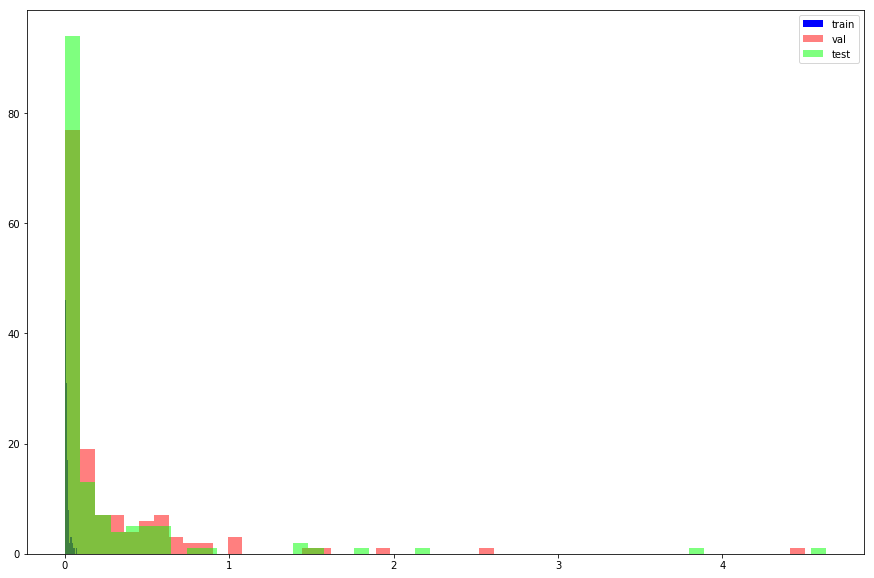

In [20]:
plt.figure(figsize=(15, 10))
plt.hist(y_train_preds_var, color='b',  bins=50, label='train')
plt.hist(y_val_preds_var, fc=(1, 0, 0, 0.5), bins=50, label='val')
plt.hist(y_test_preds_var, fc=(0, 1, 0, 0.5), bins=50, label='test')
plt.legend()
plt.show()

### Select variance threshold

In [ ]:
def accuracy(y_preds_var, y, threshold):
    for i, pred in enumerate(y_preds_var):
        if y[i, 1] == 'B':
            acc = y_preds_var < threshold
        elif y[i, 1] == 'M':
            acc = y_preds_var > threshold
            
    return acc.mean()

In [21]:
threshold = 1.2 * y_train_preds_var.mean()

In [22]:
accuracy(y_train_preds_var, y_train, threshold)

0.7473684210526316

### Validation & Test

In [23]:
accuracy(y_val_preds_var, y_val, threshold)

0.7253521126760564

In [24]:
accuracy(y_test_preds_var, y_test, threshold)

0.6971830985915493

### But best single predictive variable is not known

In [ ]:
x_healthy.loc[:, TARGET] = y_healthy
x_unhealthy.loc[:, TARGET] = y_unhealthy

In [ ]:
width = len(FEATURES + [TARGET])
f, ax = plt.subplots(figsize=(width, width))
sns.heatmap(x_healthy.corr(), annot=True, linewidths=.5, fmt= '.1f', ax=ax)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
basis = pca.fit(x_healthy.values)

In [ ]:
x_healthy_transformed = basis.transform(x_healthy)
x_unhealthy_transformed = basis.transform(x_unhealthy)

plt.figure(figsize=(width, width))
plt.scatter(x_healthy_transformed[:, 0], x_healthy_transformed[:, 1])
plt.scatter(x_unhealthy_transformed[:, 0], x_unhealthy_transformed[:, 1])

### Usage of the fewer dimentions for ensembling variance

In [ ]:
TRAIN_SIZE = int(0.8 * len(x_healthy_transformed))
np.random.seed(0)
np.random.shuffle(x_healthy_transformed)
x_train_transformed = x_healthy_transformed[:TRAIN_SIZE, :-1]
y_train_transformed = x_healthy_transformed[:TRAIN_SIZE, -1]
print('# Examples for training:',  len(x_train_transformed))

x_val_transformed = x_healthy_transformed[TRAIN_SIZE:, :-1]
y_val_transformed = x_healthy_transformed[TRAIN_SIZE:, -1]
print('# Examples for validation:',  len(x_val_transformed))

N_FEATURES_TRANSFORMED = x_val_transformed.shape[-1]

In [ ]:
models = []
N_MODELS = 5
n_hidden_neurons = 32
for _ in range(N_MODELS):
    models.append(create_base_model(N_FEATURES_TRANSFORMED, n_hidden_neurons))

In [ ]:
histories = defaultdict(lambda: None)

In [ ]:
for lr in [0.5, 0.1, 0.05, 0.01]:
    for i in range(N_MODELS):
        histories[i] = train(models[i], [x_train_transformed, y_train_transformed], (x_val_transformed, y_val_transformed), lr, 500, history=histories[i])

## Predict target feature using ensemble

In [ ]:
y_train_preds = []
y_val_preds = []
y_test_preds = []

for model in models:
    y_train_preds.append(model.predict(x_train_transformed))
    y_val_preds.append(model.predict(x_val_transformed))
    y_test_preds.append(model.predict(x_unhealthy_transformed[:, :-1]))

## Use ensemble variance to predict diagnosis 

In [ ]:
y_train_preds_var = np.var(y_train_preds, axis=0)
y_val_preds_var = np.var(y_val_preds, axis=0)
y_test_preds_var = np.var(y_test_preds, axis=0)

In [ ]:
plt.figure(figsize=(15, 10))
plt.hist(y_train_preds_var, color='b',  bins=50, label='train')
plt.hist(y_val_preds_var, fc=(1, 0, 0, 0.5), bins=50, label='val')
plt.hist(y_test_preds_var, fc=(0, 1, 0, 0.5), bins=500, label='test')
plt.legend()
plt.show()

### Select variance threshold

In [ ]:
threshold_var = 1.5 * y_train_preds_var.mean()

In [ ]:
train_acc = (y_train_preds_var < threshold_var).mean()
print(train_acc)

### Validation & Test

In [ ]:
val_acc = (y_val_preds_var < threshold_var).mean()
print(val_acc)

In [ ]:
test_acc = (y_test_preds_var >= threshold_var).mean()
print(test_acc)

Done!